<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/04-17-2020.csv"

#https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/
#csse_covid_19_data/csse_covid_19_daily_reports/04-01-2020.csv
dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative', 'totalTestResults']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative,totalTestResults
37,NY,229642,343581,573223.0
34,NJ,78467,78982,157449.0
21,MA,34402,114342,148744.0
24,MI,30023,68936,98959.0
41,PA,29441,117932,147373.0
16,IL,27575,102588,130163.0
5,CA,27528,224086,251614.0
10,FL,24119,210718,234837.0
20,LA,23118,108869,131987.0
47,TX,17371,152165,169536.0


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA[['positive', 'totalTestResults', 'death', 'deathIncrease']].sum().reset_index().copy()
dfCAPos = gbCA[['positive', 'totalTestResults', 'death', 'deathIncrease']].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [44]:
dfUSAPos[-7:]

,date,positive,totalTestResults,death,deathIncrease,PCT
43,2020-04-11,522843,2665666.0,20355,1867.0,0.752812
44,2020-04-12,551826,2805892.0,21919,1564.0,0.794543
45,2020-04-13,576774,2935006.0,23369,1450.0,0.830464
46,2020-04-14,602473,3081620.0,25668,2299.0,0.867467
47,2020-04-15,632656,3242755.0,28160,2492.0,0.910926
48,2020-04-16,663260,3401064.0,30296,2136.0,0.954990
49,2020-04-17,694520,3557493.0,32365,2069.0,1.000000


In [45]:
dfCAPos[-7:]

,date,positive,totalTestResults,death,deathIncrease,PCT
38,2020-04-11,19472,172076.0,541,0.0,0.707353
39,2020-04-12,21794,190328.0,651,110.0,0.791703
40,2020-04-13,22348,190882.0,687,36.0,0.811828
41,2020-04-14,23338,202208.0,758,71.0,0.847791
42,2020-04-15,24424,216486.0,821,63.0,0.887242
43,2020-04-16,26182,246400.0,890,69.0,0.951104
44,2020-04-17,27528,251614.0,985,95.0,1.000000


In [10]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-13,576774,2358232,17159,50968.0,62673.0,13632.0,1628.0,6168.0,210.0,35442.0,23369,62673.0,2952165,2935006.0,2935006.0,1450.0,1472.0,104166.0,24948.0,129114.0
2020-04-14,602473,2479147,16615,54215.0,67547.0,14039.0,1715.0,5975.0,221.0,37645.0,25668,67547.0,3098235,3081620.0,3081620.0,2299.0,4874.0,120915.0,25699.0,146614.0
2020-04-15,632656,2610099,16901,58361.0,69603.0,14667.0,1783.0,6032.0,223.0,39405.0,28160,69603.0,3259656,3242755.0,3242755.0,2492.0,2056.0,130952.0,30183.0,161135.0
2020-04-16,663260,2737804,16927,57494.0,74705.0,15150.0,1834.0,5940.0,137.0,42032.0,30296,74705.0,3417991,3401064.0,3401064.0,2136.0,5396.0,127705.0,30604.0,158309.0
2020-04-17,694520,2862973,10889,56963.0,77955.0,14910.0,2052.0,6096.0,148.0,44139.0,32365,77955.0,3568382,3557493.0,3557493.0,2069.0,3250.0,125169.0,31260.0,156429.0


In [11]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-13,22348,168534,13200,3015.0,0.0,1178.0,0.0,0.0,0.0,0.0,687,0.0,204082,190882.0,190882.0,36.0,0.0,0.0,554.0,554.0
2020-04-14,23338,178870,13200,5163.0,0.0,1552.0,0.0,0.0,0.0,0.0,758,0.0,215408,202208.0,202208.0,71.0,0.0,10336.0,990.0,11326.0
2020-04-15,24424,192062,13200,5163.0,0.0,1175.0,0.0,0.0,0.0,0.0,821,0.0,229686,216486.0,216486.0,63.0,0.0,13192.0,1086.0,14278.0
2020-04-16,26182,220218,13200,5031.0,0.0,1568.0,0.0,0.0,0.0,0.0,890,0.0,259600,246400.0,246400.0,69.0,0.0,28156.0,1758.0,29914.0
2020-04-17,27528,224086,7200,4892.0,0.0,1484.0,0.0,0.0,0.0,0.0,985,0.0,258814,251614.0,251614.0,95.0,0.0,3868.0,1346.0,5214.0


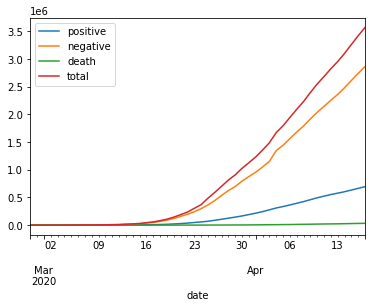

In [12]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [13]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
2020-04-04,241703,5854
2020-04-05,273808,7020
2020-04-06,307318,8358
2020-04-07,333811,9559
2020-04-08,363321,10845
2020-04-09,395939,12740
2020-04-10,425889,14665
2020-04-11,461275,16596
2020-04-12,492881,18516


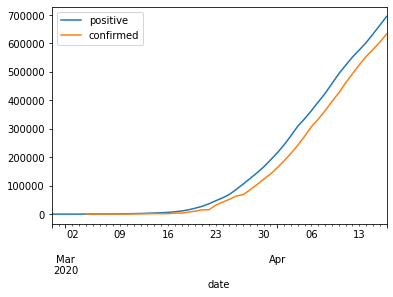

In [14]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [15]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-11,19472,152604,13200,5236.0,0.0,1591.0,0.0,0.0,0.0,0.0,541,0.0,185276,172076.0,172076.0,0.0,0.0,7213.0,0.0,7213.0
2020-04-12,21794,168534,13200,5234.0,0.0,1539.0,0.0,0.0,0.0,0.0,651,0.0,203528,190328.0,190328.0,110.0,0.0,15930.0,2322.0,18252.0
2020-04-13,22348,168534,13200,3015.0,0.0,1178.0,0.0,0.0,0.0,0.0,687,0.0,204082,190882.0,190882.0,36.0,0.0,0.0,554.0,554.0
2020-04-14,23338,178870,13200,5163.0,0.0,1552.0,0.0,0.0,0.0,0.0,758,0.0,215408,202208.0,202208.0,71.0,0.0,10336.0,990.0,11326.0
2020-04-15,24424,192062,13200,5163.0,0.0,1175.0,0.0,0.0,0.0,0.0,821,0.0,229686,216486.0,216486.0,63.0,0.0,13192.0,1086.0,14278.0
2020-04-16,26182,220218,13200,5031.0,0.0,1568.0,0.0,0.0,0.0,0.0,890,0.0,259600,246400.0,246400.0,69.0,0.0,28156.0,1758.0,29914.0
2020-04-17,27528,224086,7200,4892.0,0.0,1484.0,0.0,0.0,0.0,0.0,985,0.0,258814,251614.0,251614.0,95.0,0.0,3868.0,1346.0,5214.0


In [16]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    699706
dead          36773
dtype: int64

In [17]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    29157
dead          1037
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [19]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                699706
Spain             190839
Italy             172434
France            149130
Germany           141397
United Kingdom    109769
China              83760
Iran               79494
Turkey             78546
Belgium            36138
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [24]:
dfState.loc['FL'].head(7)

,date,positive,current_total,pct
state,,,,
FL,2020-04-17,24119,24119,1.000000
FL,2020-04-16,22897,24119,0.949335
FL,2020-04-15,22511,24119,0.933331
FL,2020-04-14,21367,24119,0.885899
FL,2020-04-13,20601,24119,0.854140
FL,2020-04-12,19355,24119,0.802479
FL,2020-04-11,18494,24119,0.766781


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

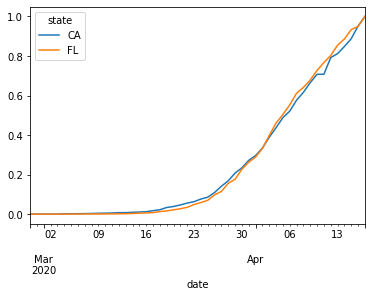

In [26]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

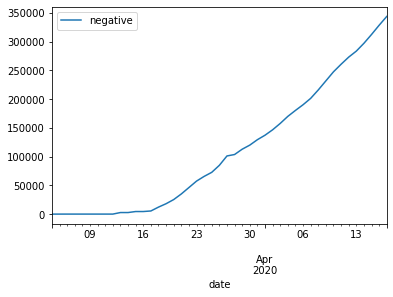

In [28]:
x = dfNYTesting.plot.line()

In [29]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,current_total,pct
424,FL,2020-04-17,24119,24119,1.000000
425,FL,2020-04-16,22897,24119,0.949335
426,FL,2020-04-15,22511,24119,0.933331
427,FL,2020-04-14,21367,24119,0.885899
428,FL,2020-04-13,20601,24119,0.854140
429,FL,2020-04-12,19355,24119,0.802479
430,FL,2020-04-11,18494,24119,0.766781
431,FL,2020-04-10,17531,24119,0.726854
432,FL,2020-04-09,16364,24119,0.678469
433,FL,2020-04-08,15455,24119,0.640781


In [30]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=3)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .7)].sort_values(by='pct')


,state,date,positive,current_total,pct


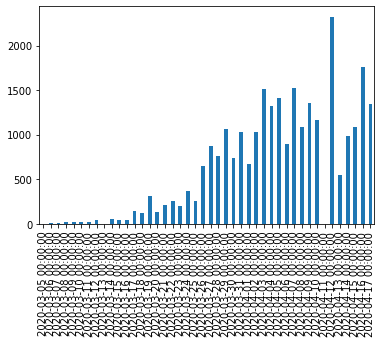

In [31]:
state = 'CA'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar()



# Added State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [34]:
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")

positive     694520
negative    2862973
pending       10889
death         32365
total       3568382
dtype: int64
Current Infection Rate 19.463163%
Percentage of US affected: 0.221450%
Percentage of US tested/affected: 1.093670%


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [42]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:51]

,state_pos_pop,state_test_pop
state,,
NY,1.180463,2.946622
NJ,0.883420,1.772637
MA,0.499122,2.158055
LA,0.497290,2.839166
CT,0.471463,1.555611
RI,0.394294,2.903732
DC,0.350833,1.791430
MI,0.300625,0.990892
DE,0.238559,1.439466
